METIS PROJECT 4: Game of Thrones

In [1]:
import pandas as pd
import numpy as np
import re
import codecs
import json
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import sent_tokenize
from textblob import TextBlob
from copy import deepcopy
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
import multiprocessing
import gensim
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
#from nltk.tokenize import WhitespaceTokenizer
#from scipy.interpolate import spline
#import scipy
#from itertools import chain

%matplotlib inline

pd.options.display.float_format = '{:20,.3f}'.format
pd.options.display.max_columns = 15
pd.options.display.max_rows = 500

In [2]:
def make_df(filename):
    # make list of chapters
    book = make_file(filename)
    
    # turn book into dataframe
    book_df = pd.DataFrame(book)
    book_df.columns = ['chapter_text']
    
    # add column with chapter's POV character
    book_df['chapter_name'] = book_df['chapter_text'].apply(chap_char)
    
    # remove chapter title from chapter_text
    book_df['chapter_text'] = book_df.apply(lambda row: row['chapter_text'][len(row['chapter_name']):], axis=1)
    
    # add column with book title
    title = book_df.ix[0, 1]
    book_df['book_title'] = title
    
    # drop first row with book basic info
    book_df.drop(0, inplace=True)
    
    # add column with chapter number
    book_df['chapter_num'] = book_df.index
    book_df = book_df[['book_title', 'chapter_num', 'chapter_name', 'chapter_text']]
    
    return book_df

    
def make_file(filename):
    # read in book text by line
    with codecs.open(filename, mode='r') as f:
        txt = f.read().splitlines()
    
    # concatinate lines in the same chapter
    book = []
    # initialize to false for first chapter
    end = False 
    
    for i in range(0, len(txt)):
        # remove page numbers and chapter headers
        txt[i] = re.sub('Page [0-9]*', '', txt[i])
        txt[i] = re.sub('Chapter [0-9]*', '', txt[i])
        
        # skip blank lines
        if not txt[i] or re.match("^ *$", txt[i]):
            continue
        
        # find chapter begining which start with character name capitalized
        elif re.match("^[ A-Z]*$", txt[i]):
            if end:
                # append previous chapter to list (false for first chapter)
                book.append(chapter) 
            # start new chapter
            chapter = txt[i]
            # set end to true for subsequent chapters after first chapter
            end = True
        
        # if not begining of chapter, add lines to chapter
        else:
            chapter = chapter + txt[i]
    book.append(chapter)
    return book


def chap_char(x):
    # Find character name in all caps
    name = re.findall(r'^[ A-Z]*', x)
    
    # clean name
    name = name[0]
    name = name[:-1]
    name = name.strip()
    if name[-2:] == ' A':
        name = name[:-2]
        name = name.strip() 
    return name


def sent_breakout(x, n):
    scores =[]
    for i in x:
        score = TextBlob(i).sentiment[n]
        scores.append(score)
    return scores


def sentiment_smooth(data, smooth=10):
    y = np.array(data)
    x = np.array(range(0, len(y)))

    x_smooth = np.linspace(x.min(), x.max(), smooth)
    
    groups = np.array_split(y, smooth)
    
    y_smooth = []
    for group in groups:
        y_smooth.append(group.mean())
    
    figure, ax = plt.subplots(figsize=(15, 5))
    plt.plot(x_smooth, y_smooth);
    d = np.zeros(len(y_smooth))
    ax.fill_between(x_smooth, y_smooth, where=y_smooth >= d, interpolate=True, color='yellow')
    ax.fill_between(x_smooth, y_smooth, where=y_smooth <= d, interpolate=True, color='red')
    plt.xlim(0, x.max())
    
    
def sentiment_runavg(data, runavg=10):
    y = np.array(data)    
    
    y_runavg = np.convolve(y, np.ones((runavg,))/runavg, mode='valid')
    x = np.array(range(0, len(y_runavg)))
    
    figure, ax = plt.subplots(figsize=(25, 7))
    plt.plot(x, y_runavg);
    d = np.zeros(len(y_runavg))
    ax.fill_between(x, y_runavg, where=y_runavg >= d, interpolate=True, color='yellow')
    ax.fill_between(x, y_runavg, where=y_runavg <= d, interpolate=True, color='red')
    plt.xlim(0, x.max())
    
    
def remove_stops(document):
    for i, x in enumerate(document):
        x = re.sub(r'[^a-zA-Z ]','', x)
        x = x.lower()
        document[i] = x.split()
    
    stoplist = stopwords.words('english') + ['ii']
    
    new_doc = [[word for word in sentence if word not in stoplist]
         for sentence in document]
    return new_doc


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print "Topic #%d:" % topic_idx
        print " ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]])
        
        
def char_sent_plot(name, n):
    char_chap = ice_and_fire.sentence_polarity[ice_and_fire.pov == name]
    char = []
    for chapter in char_chap:
        char += chapter

    sentiment_runavg(char, runavg=n)

In [3]:
# Make dataframe for each book
file1 = "GOTbooks/001ssb.txt"
file2 = "GOTbooks/002ssb.txt"
file3 = "GOTbooks/003ssb.txt"
file4 = "GOTbooks/004ssb.txt"
file5 = "GOTbooks/005ssb.txt"

game_of_thrones = make_df(file1)
clash_of_kings = make_df(file2)
storm_of_swords = make_df(file3)
feast_for_crows = make_df(file4)
dance_with_dragons = make_df(file5)


In [4]:
# Join books into one dataframe
book_names = [game_of_thrones, clash_of_kings, storm_of_swords, feast_for_crows, dance_with_dragons]
ice_and_fire = pd.concat(book_names)
ice_and_fire.reset_index(inplace=True, drop=True)

In [5]:
ice_and_fire.head()

,book_title,chapter_num,chapter_name,chapter_text
0,A GAME OF THRONES,1,PROLOGUE,"""We should start back,"" Gared urged as the wo..."
1,A GAME OF THRONES,2,BRAN,"The morning had dawned clear and cold, with a..."
2,A GAME OF THRONES,3,CATELYN,Catelyn had never liked this godswood. She ha...
3,A GAME OF THRONES,4,DAENERYS,Her brother held the gown up for her inspecti...
4,A GAME OF THRONES,5,EDDARD,The visitors poured through the castle gates ...


In [6]:
ice_and_fire.shape

(344, 4)

In [7]:
# Read in scraped Wiki data
with open('GOTscrapy/got_wiki.json') as filename:
    json_data = json.load(filename)

wiki = pd.DataFrame(json_data)
wiki.head()

,book,chronology,pov,setting
0,A Game of Thrones,Prologue,Will,Haunted forest
1,A Game of Thrones,Bran I,Bran Stark,Winterfell
2,A Game of Thrones,Catelyn I,Catelyn Stark,Winterfell
3,A Game of Thrones,Daenerys I,Daenerys Targaryen,Pentos
4,A Game of Thrones,Eddard I,Eddard Stark,Winterfell


In [8]:
wiki.shape

(344, 4)

In [9]:
# Join book data and scraped data
ice_and_fire = ice_and_fire.join(wiki)

In [10]:
# Drop duplicate data and rearrange columns
ice_and_fire.drop(['book'], axis=1, inplace=True)
df_names = ['book_title', 'chapter_num', 'chapter_name', 'pov', 'chronology', 'setting', 'chapter_text']
ice_and_fire = ice_and_fire[df_names]
ice_and_fire.head()

,book_title,chapter_num,chapter_name,pov,chronology,setting,chapter_text
0,A GAME OF THRONES,1,PROLOGUE,Will,Prologue,Haunted forest,"""We should start back,"" Gared urged as the wo..."
1,A GAME OF THRONES,2,BRAN,Bran Stark,Bran I,Winterfell,"The morning had dawned clear and cold, with a..."
2,A GAME OF THRONES,3,CATELYN,Catelyn Stark,Catelyn I,Winterfell,Catelyn had never liked this godswood. She ha...
3,A GAME OF THRONES,4,DAENERYS,Daenerys Targaryen,Daenerys I,Pentos,Her brother held the gown up for her inspecti...
4,A GAME OF THRONES,5,EDDARD,Eddard Stark,Eddard I,Winterfell,The visitors poured through the castle gates ...


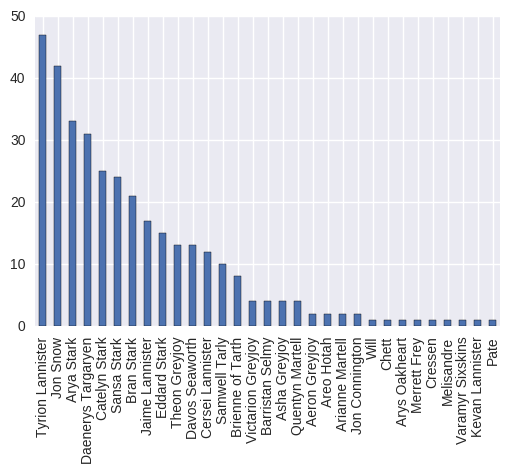

In [11]:
# POV character chapters
ice_and_fire.pov.value_counts().plot(kind='bar');

In [13]:
ice_and_fire.setting.value_counts()

King's Landing                 80
Castle Black                   32
Winterfell                     30
Meereen                        17
Riverrun                       12
Dragonstone                     7
Harrenhal                       7
Braavos                         6
Riverlands                      6
Eyrie                           6
Fist of the First Men           5
Blackwater Bay                  4
Dothraki Sea                    4
Qarth                           4
the Twins                       4
Sunspear                        3
haunted forest                  3
White Harbor                    3
Vaes Dothrak                    3
Storm's End                     3
Summer Sea                      3
Yunkish                         3
Skirling Pass                   3
Maidenpool                      3
Inn of the Kneeling Man         2
Moat Cailin                     2
Queenscrown                     2
Pentos                          2
High Heart                      2
Darry         

In [14]:
# Break up chapters into sentences
ice_and_fire['sentences'] = ice_and_fire.chapter_text.apply(sent_tokenize)

In [15]:
# Sentiment Analysis of sentences in each chapter
ice_and_fire['sentence_polarity'] = ice_and_fire['sentences'].apply(lambda x: sent_breakout(x, 0))
ice_and_fire['sentence_subjectivity'] = ice_and_fire['sentences'].apply(lambda x: sent_breakout(x, 1))

In [15]:
# Total number of sentences across all books
count = 0
for x in ice_and_fire.sentences:
    a = len(x)
    count += a
    
count

158053

In [16]:
# Remove stop words from sentences
ice_and_fire['sentences_stop'] = deepcopy(ice_and_fire['sentences'])
ice_and_fire['sentences_stop'] = ice_and_fire['sentences_stop'].apply(remove_stops)

In [17]:
ice_and_fire.head()

,book_title,chapter_num,chapter_name,pov,chronology,setting,chapter_text,sentences,sentence_polarity,sentence_subjectivity,sentences_stop
0,A GAME OF THRONES,1,PROLOGUE,Will,Prologue,Haunted forest,"""We should start back,"" Gared urged as the wo...","[ ""We should start back,"" Gared urged as the w...","[-0.075, -0.2, -0.2, 0.3, 0.0, -0.075, -0.2, -...","[0.2, 0.4, 0.4, 0.1, 0.0, 0.225, 0.4, 0.4, 0.4...","[[start, back, gared, urged, woods, began, gro..."
1,A GAME OF THRONES,2,BRAN,Bran Stark,Bran I,Winterfell,"The morning had dawned clear and cold, with a...","[ The morning had dawned clear and cold, with ...","[-0.25, 0.0, 0.116666666667, 0.0, -0.125, 0.0,...","[0.691666666667, 0.0, 0.344444444444, 0.0, 0.2...","[[morning, dawned, clear, cold, crispness, hin..."
2,A GAME OF THRONES,3,CATELYN,Catelyn Stark,Catelyn I,Winterfell,Catelyn had never liked this godswood. She ha...,"[ Catelyn had never liked this godswood., She ...","[-0.3, 0.05, 0.266666666667, 0.0, 0.1375, 0.0,...","[0.8, 0.5, 0.566666666667, 0.6, 0.3875, 0.0, 0...","[[catelyn, never, liked, godswood], [born, tul..."
3,A GAME OF THRONES,4,DAENERYS,Daenerys Targaryen,Daenerys I,Pentos,Her brother held the gown up for her inspecti...,[ Her brother held the gown up for her inspect...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4, 0.1, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.35, 0.0,...","[[brother, held, gown, inspection], [beauty], ..."
4,A GAME OF THRONES,5,EDDARD,Eddard Stark,Eddard I,Winterfell,The visitors poured through the castle gates ...,[ The visitors poured through the castle gates...,"[0.433333333333, 0.15, 0.5, -0.15, -0.021875, ...","[0.733333333333, 0.25, 0.5, 0.9, 0.77222222222...","[[visitors, poured, castle, gates, river, gold..."
5,A GAME OF THRONES,6,JON,Jon Snow,Jon I,Winterfell,"There were times-not many, but a few-when Jon...","[ There were times-not many, but a few-when Jo...","[0.5, 0.45, 0.0, 0.35, 0.3, -0.05, -0.1, 0.001...","[0.75, 0.7, 0.0, 0.55, 0.625, 0.1, 0.3, 0.3072...","[[timesnot, many, fewwhen, jon, snow, glad, ba..."
6,A GAME OF THRONES,7,CATELYN,Catelyn Stark,Catelyn II,Winterfell,"Of all the rooms in Winterfell's Great Keep, ...","[ Of all the rooms in Winterfell's Great Keep,...","[0.8, 0.4, 0.175, -0.125, -0.1875, 0.425, 0.0,...","[0.75, 0.7, 0.625, 0.45, 0.5, 0.725, 0.0, 0.64...","[[rooms, winterfells, great, keep, catelyns, b..."
7,A GAME OF THRONES,8,ARYA,Arya Stark,Arya I,Winterfell,Arya's stitches were crooked again. She frown...,"[ Arya's stitches were crooked again., She fro...","[0.0, -0.140277777778, 1.0, 0.0, 0.25, 0.03888...","[0.1, 0.331944444444, 1.0, 0.0, 1.0, 0.6333333...","[[aryas, stitches, crooked], [frowned, dismay,..."
8,A GAME OF THRONES,9,BRAN,Bran Stark,Bran II,Winterfell,The hunt left at dawn. The king wanted wild b...,"[ The hunt left at dawn., The king wanted wild...","[0.0, 0.1, 0.0, 0.03125, 0.0, 0.0, -0.2, 0.0, ...","[0.0, 0.4, 0.0, 0.75, 0.0666666666667, 0.0, 0....","[[hunt, left, dawn], [king, wanted, wild, boar..."
9,A GAME OF THRONES,10,TYRION,Tyrion Lannister,Tyrion I,Winterfell,Somewhere in the great stone maze of Winterfe...,[ Somewhere in the great stone maze of Winterf...,"[0.8, 0.4, 0.6, 0.0339285714286, -0.2, 0.0, 0....","[0.75, 0.4, 0.6, 0.333928571429, 0.5, 0.0, 0.6...","[[somewhere, great, stone, maze, winterfell, w..."


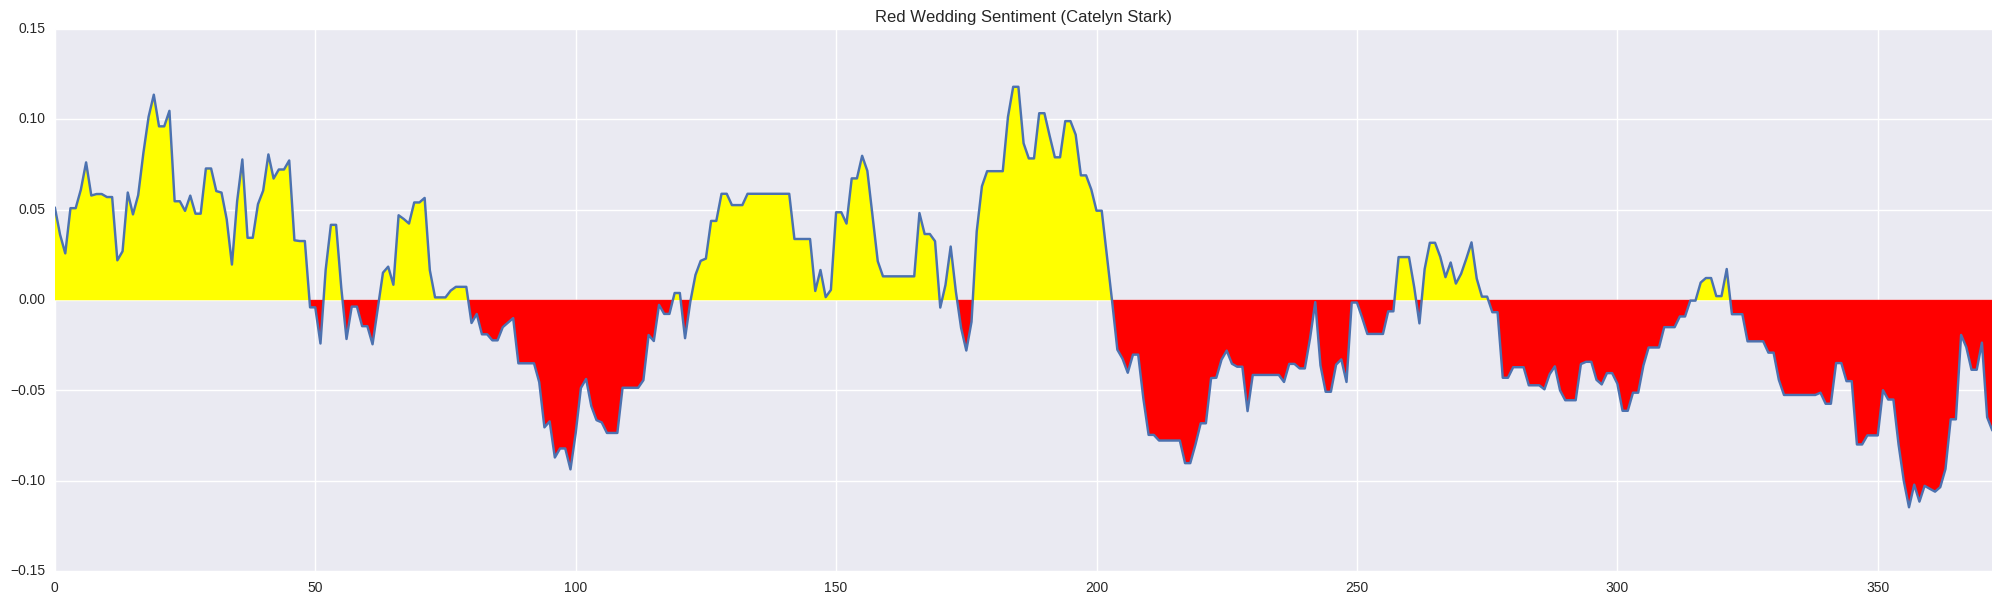

In [19]:
# Red Wedding sentiment from Catelyn's POV
sentiment_runavg(ice_and_fire.ix[194, 8], runavg=20)
plt.title('Red Wedding Sentiment (Catelyn Stark)');

In [20]:
# 

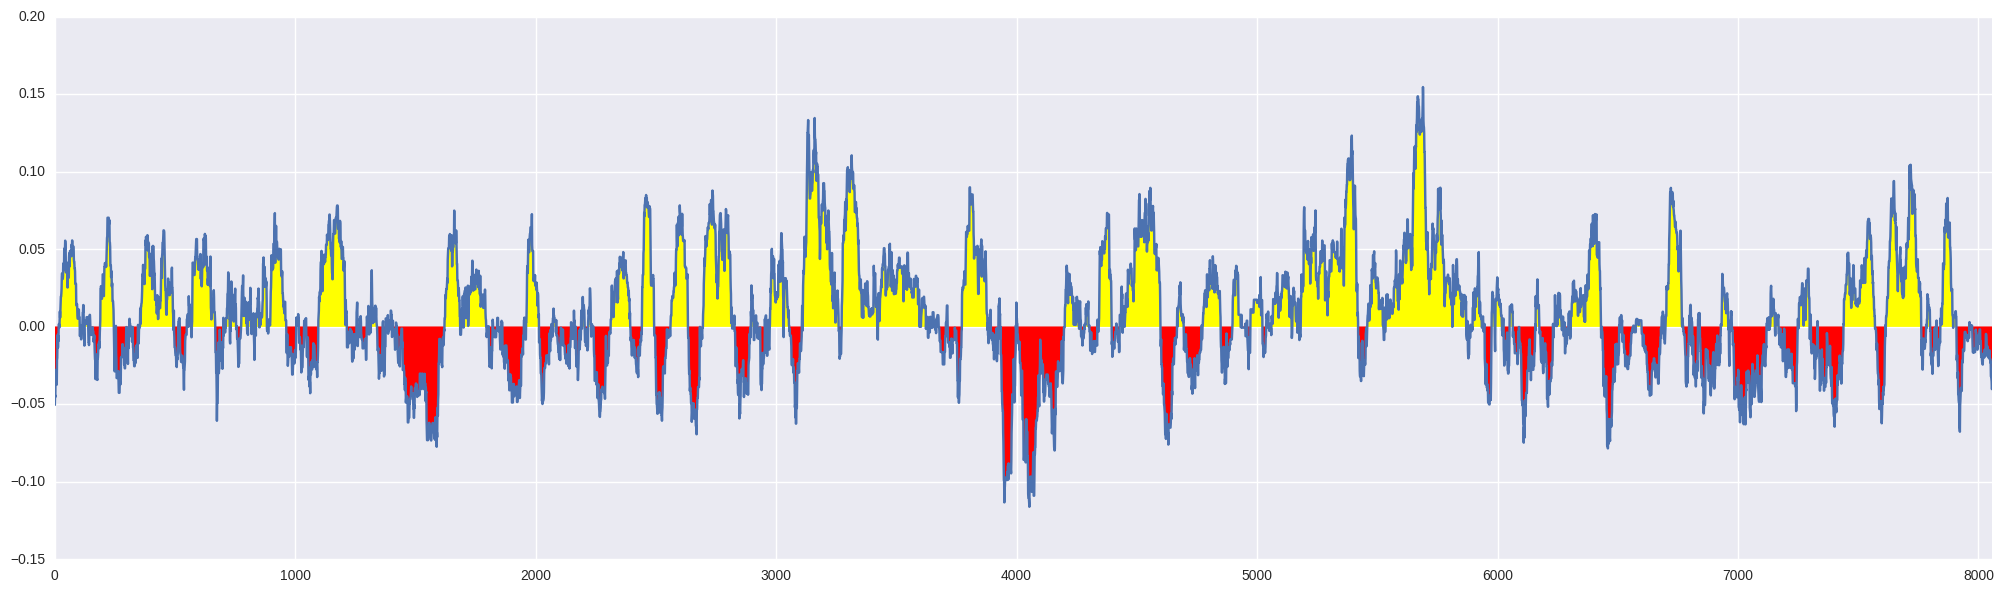

In [21]:
char_sent_plot("Bran Stark", n=50)

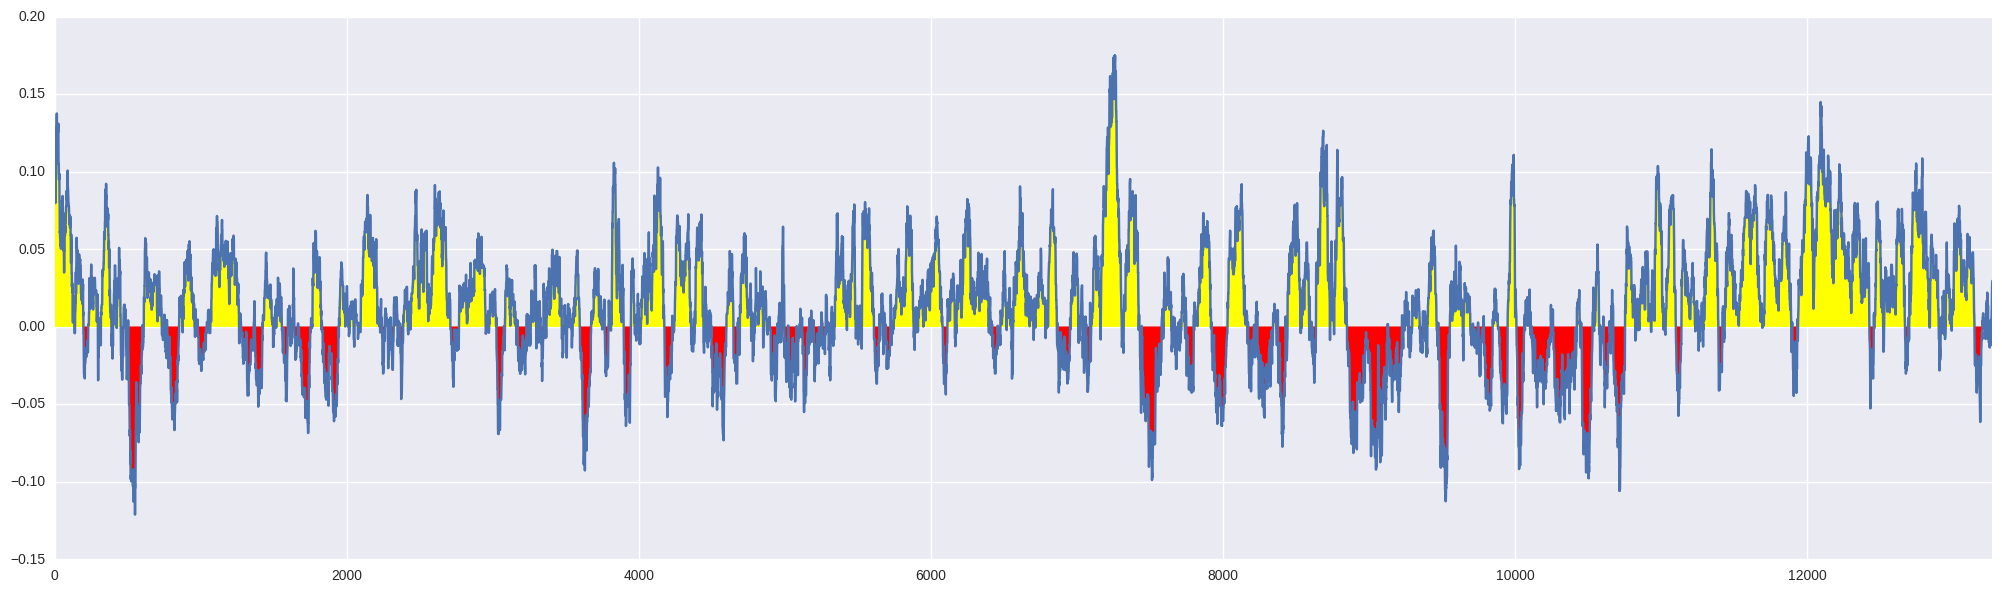

In [22]:
char_sent_plot("Arya Stark", n=50)

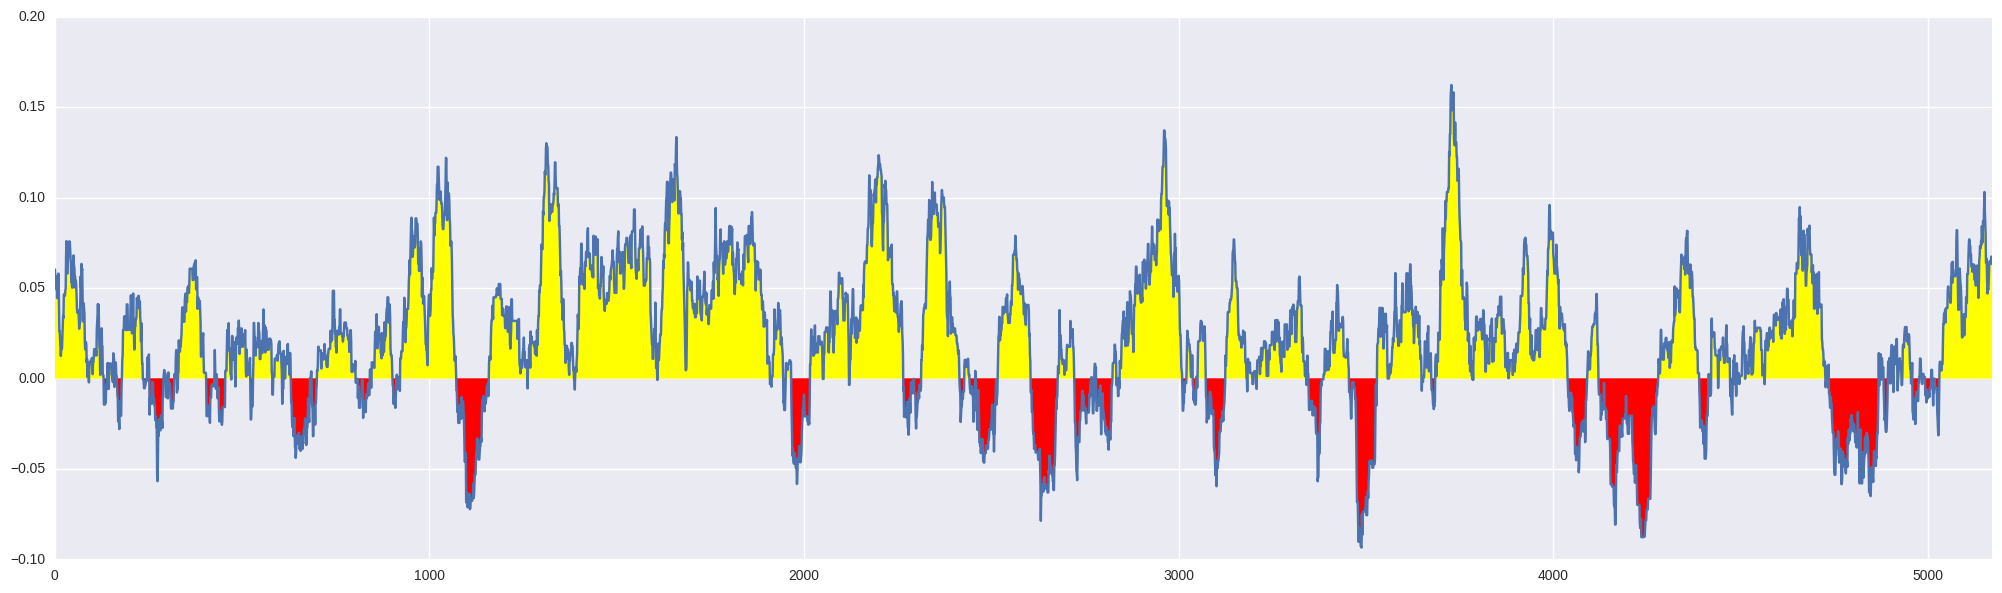

In [23]:
char_sent_plot("Eddard Stark", n=50)

'characters = [\n    "ned",\n    "catelyn",\n    "robb",\n    "sansa",\n    "arya",\n    "bran",\n    "rickon",\n    "jon",    #Snow, Arryn\n    "benjen",\n    "roose",\n    "ramsay",\n    "hodor",\n    "osha",\n    "jojen",\n    "meera",\n    "daenerys",\n    "dany",\n    "viserys",\n    "jorah",\n    "missandei",\n    "daario",\n    "worm",\n    "tywin",\n    "cersei",\n    "jaime",\n    "tyrion",\n    "joffrey",\n    "myrcella",\n    "tommen",\n    "kevan",\n    "lancel",\n    "bronn",\n    "gregor",\n    "mountain",\n    "sandor",\n    "hound",\n    "podrick",\n    "robert",    #Baratheon, Arryn\n    "stannis",\n    "selyse",\n    "shireen",\n    "melisandre"\n    "davos",\n    "renly",\n    "brienne",\n    "beric",\n    "gendry",\n    "lysa"\n    "theon",\n    "reek",\n    "balon",\n    "asha",\n    "euron",\n    "victarion",\n    "doran",\n    "arianne",\n    "quentyn",\n    "trystane",\n    "elia",\n    "oberyn",\n    "viper",\n    "ellaria",\n    "obara",\n    "tyene",\n    "ar

In [25]:
males = [
    'Tyrion Lannister', 
    'Jon Snow', 
    'Bran Stark', 
    'Jaime Lannister', 
    'Eddard Stark', 
    'Theon Greyjoy', 
    'Davos Seaworth',
    'Samwell Taryl',
    'Victarion Greyjoy',
    'Barristan Selmy',
    'Quentyn Martell',
    'Aeron Greyjoy',
    'Areo Hotah',
    'Jon Connington',
    'Will',
    'Chet',
    'Arys Oakheart',
    'Merrett Frey',
    'Cressen',
    'Varamyr Sixskins',
    'Kevan Lannister',
    'Pate'
    
]

females = [
    'Arya Stark', 
    'Daenerys Targaryen', 
    'Catelyn Stark', 
    'Sansa Stark',
    'Cersei Lannister',
    'Brienne of Tarth',
    'Asha Greyjoy',
    'Arianne Martell',
    'Melisandre'
]

male_chaps = ice_and_fire.loc[ice_and_fire['pov'].isin(males)]
print len(male_chaps)

female_chaps = ice_and_fire.loc[ice_and_fire['pov'].isin(females)]
print len(female_chaps)

193
140


In [ ]:
#Countvectorizer/lda
count_vectorizer = CountVectorizer(
    ngram_range=(1, 2),  
    stop_words='english', 
    token_pattern="\\b[a-z][a-z]+\\b")

In [26]:
n_topics = 5
n_top_words = 20

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7, min_df=0.05)

tfidf = tfidf_vectorizer.fit_transform(female_chaps.chapter_text)

nmf = NMF(n_components=n_topics, random_state=1, alpha=.1, l1_ratio=.5).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)


Topic #0:
catelyn robb edmure walder ned frey riverrun greatjon brynden lysa renly rodrik lannister bran karstark theon hoster tully winterfell tywin
Topic #1:
dany jorah drogo khal dothraki dragon hizdahr meereen viserys daario dragons khaleesi unsullied belwas yunkai illyrio irri grace astapor daenerys
Topic #2:
arya gendry pie yoren lem tom hot hound beric lommy needle thoros syrio weese maybe harwin clegane anguy jaqen harrenhal
Topic #3:
sansa cersei joffrey margaery grace tommen dontos septa petyr loras tyrion tyrell robert pycelle stannis jaime joff prince qyburn boros
Topic #4:
brienne podrick renly dick tarly septon maidenpool duskendale nimble dog inn jaime catelyn hunt saltpans road tarth randyll maid elder


In [27]:
n_topics = 5
n_top_words = 20

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.1, min_df=0.05)

tfidf = tfidf_vectorizer.fit_transform(male_chaps.chapter_text)

nmf = NMF(n_components=n_topics, random_state=1, alpha=.1, l1_ratio=.5).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topic #0:
davos saan salladhor wyman axell smuggler seaworth devan selyse hllor shireen alester patchface den pirate glover shortened lamprey lysene hull
Topic #1:
tormund val rattleshirt magnar pyp yarwyck giantsbane clydas harma mammoths selyse dalla othell styr mully leathers eagle thorne skinchanger cotter
Topic #2:
meera jojen osha net elk frog basket brynden deer nightfort shaggydog warg muzzle male bet umbers wolfswood paws female turret
Topic #3:
brienne vargo hoat tarth mummers ilyn innkeep wrists edmure robin addam arthur whent ransom marbrand northman oberyn crakehall trant darry
Topic #4:
reek ramsay jeyne wyman asha rowan aenys dick whoresbane flay keys rickard flayed boom squirrel serjeant cerwyn tallhart osha hunter


In [28]:
n_topics = 20
n_top_words = 20

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.25, min_df=0.05)

tfidf = tfidf_vectorizer.fit_transform(ice_and_fire.chapter_text)

nmf = NMF(n_components=n_topics, random_state=1, alpha=.1, l1_ratio=.5).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topic #0:
margaery tommen tyrell loras kevan qyburn merryweather osmund osney kettleblack lancel pycelle joff highgarden gyles mace dontos boros redwyne meryn
Topic #1:
dany jorah drogo khal dothraki khaleesi viserys irri jhiqui drogon jhogo unsullied khalasar slaves aggo qarth meereen bloodriders astapor missandei
Topic #2:
sam aemon grenn craster pyp samwell tarly alliser edd janos corn slayer babe thorne dolorous oldtown slynt dywen marsh books
Topic #3:
theon greyjoy luwin rodrik pyke islands tallhart direwolves rickon moat torrhen mikken jeyne deepwood ironmen rowan battlements balon motte bitch
Topic #4:
brienne wench podrick tarth dick maidenpool inn vargo duskendale hoat tarly harrenhal bolton aerys stump goat kingslayer innkeep qyburn elder
Topic #5:
hodor luwin rickon rodrik nan reed net brandon walder hornwood weirwood stories basket lake godswood elk mikken frog reeds ranger
Topic #6:
mance tormund ygritte wildlings qhorin rayder halfhand wildling val magnar marsh edd noye 

In [5]:
# combine all books to one string
all_books = ""
for x in ice_and_fire.chapter_text:
    all_books = all_books + x

# tokenize sentences
all_books = sent_tokenize(all_books)

for i, x in enumerate(all_books):
    x = re.sub(r'[^a-zA-Z ]','', x)
    x = x.lower()
    all_books[i] = x.split()

In [7]:
'''# combine all books to one string
all_books = ""
files = [
    'GOTbooks/game_of_thrones.txt', 
    'GOTbooks/storm_of_swords.txt', 
    'GOTbooks/clash_of_kings.txt', 
    'GOTbooks/feast_for_crows.txt', 
    'GOTbooks/dance_with_dragons.txt']

for doc in files:
    with open(doc, 'r') as f:
        f = f.read()
    all_books = all_books + f
'''

'# combine all books to one string\nall_books = ""\nfiles = [\n    \'GOTbooks/game_of_thrones.txt\', \n    \'GOTbooks/storm_of_swords.txt\', \n    \'GOTbooks/clash_of_kings.txt\', \n    \'GOTbooks/feast_for_crows.txt\', \n    \'GOTbooks/dance_with_dragons.txt\']\n\nfor doc in files:\n    with open(doc, \'r\') as f:\n        f = f.read()\n    all_books = all_books + f\n'

In [8]:
token_count = sum([len(sentence) for sentence in all_books])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 1,734,786 tokens


In [9]:
# "We should start back," Gared urged as the woods began to grow dark around them.
all_books[0]

['we',
 'should',
 'start',
 'back',
 'gared',
 'urged',
 'as',
 'the',
 'woods',
 'began',
 'to',
 'grow',
 'dark',
 'around',
 'them']

In [6]:
num_features = 100
context_size = 7
min_word_count = 3
num_workers = multiprocessing.cpu_count()


thrones2vec = gensim.models.Word2Vec(
    all_books, 
    size=num_features, 
    window=context_size, 
    min_count=min_word_count, 
    workers=num_workers,
    sg=1,
    seed=1
)

In [43]:
thrones2vec.most_similar('king')

[('usurper', 0.7893590927124023),
 ('baratheon', 0.7273122072219849),
 ('robert', 0.7219042778015137),
 ('aerys', 0.7201244831085205),
 ('traitor', 0.7142062187194824),
 ('grandson', 0.7039636373519897),
 ('rightful', 0.6990010738372803),
 ('proclaim', 0.6912393569946289),
 ('beloved', 0.690644383430481),
 ('ii', 0.689614474773407)]

In [44]:
thrones2vec.most_similar("stark")

[('starks', 0.7633678913116455),
 ('eddard', 0.7544721364974976),
 ('torrhen', 0.7198936939239502),
 ('winterfell', 0.719672441482544),
 ('robb', 0.7006678581237793),
 ('lyanna', 0.6980304718017578),
 ('arryn', 0.6863338947296143),
 ('tully', 0.6840125918388367),
 ('brandon', 0.6811233758926392),
 ('eddards', 0.6686800718307495)]

In [45]:
thrones2vec.most_similar("direwolf")

[('wolf', 0.7288039922714233),
 ('pup', 0.7146111726760864),
 ('wight', 0.7082374095916748),
 ('ghost', 0.7055807709693909),
 ('robb', 0.7037683129310608),
 ('flash', 0.6661661863327026),
 ('stark', 0.6597589254379272),
 ('banner', 0.6595895886421204),
 ('nymeria', 0.6505183577537537),
 ('bran', 0.6499446630477905)]

In [46]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))

nearest_similarity_cosmul("stark", "winterfell", "riverrun")
nearest_similarity_cosmul("jaime", "sword", "wine")
nearest_similarity_cosmul("arya", "nymeria", "dragons")
nearest_similarity_cosmul("reek", "theon", "arya")
nearest_similarity_cosmul("sword", "jaime", "tyrion")

stark is related to winterfell, as tully is related to riverrun
jaime is related to sword, as tyrion is related to wine
arya is related to nymeria, as dany is related to dragons
reek is related to theon, as rayder is related to mance
sword is related to jaime, as blade is related to tyrion


In [47]:
thrones2vec.most_similar("dorne")

[('sunspear', 0.7591980695724487),
 ('trystane', 0.7558854222297668),
 ('lawful', 0.7520732283592224),
 ('lannisport', 0.7388244867324829),
 ('mistress', 0.7320163249969482),
 ('dornes', 0.7313121557235718),
 ('pentos', 0.729732871055603),
 ('kingdom', 0.7287875413894653),
 ('issue', 0.7262702584266663),
 ('stormlands', 0.7193938493728638)]

In [7]:
thrones_matrix = PCA(n_components=25, random_state=0).fit_transform(thrones2vec.syn0)

In [ ]:
thrones_matrix_2d = TSNE(n_components=2, random_state=0).fit_transform(thrones_matrix)

In [ ]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.vocab[word].index])
            for word in thrones2vec.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [ ]:
'''characters = [
    "ned",
    "catelyn",
    "robb",
    "sansa",
    "arya",
    "bran",
    "rickon",
    "jon",    #Snow, Arryn
    "benjen",
    "roose",
    "ramsay",
    "hodor",
    "osha",
    "jojen",
    "meera",
    "daenerys",
    "dany",
    "viserys",
    "jorah",
    "missandei",
    "daario",
    "worm",
    "tywin",
    "cersei",
    "jaime",
    "tyrion",
    "joffrey",
    "myrcella",
    "tommen",
    "kevan",
    "lancel",
    "bronn",
    "gregor",
    "mountain",
    "sandor",
    "hound",
    "podrick",
    "robert",    #Baratheon, Arryn
    "stannis",
    "selyse",
    "shireen",
    "melisandre"
    "davos",
    "renly",
    "brienne",
    "beric",
    "gendry",
    "lysa"
    "theon",
    "reek",
    "balon",
    "asha",
    "euron",
    "victarion",
    "doran",
    "arianne",
    "quentyn",
    "trystane",
    "elia",
    "oberyn",
    "viper",
    "ellaria",
    "obara",
    "tyene",
    "areo",
    "hoster",
    "edmure",
    "brynden",
    "blackfish",
    "walder",
    "mace",
    "loras",
    "margaery",
    "olenna",
    "thorns",
    "randyll",
    "jeor",
    "mormont",
    "aemon",
    "yoren",
    "samwell",
    "sam",
    "janos",
    "alliser",
    "mance",
    "ygritte",
    "craster",
    "gilly",
    "tormund",
    "petyr",
    "varys",
    "pycelle",
    "barristan",
    "qyburn",
    "drogo",
    "syrio",
    "jaqen",
    "illyrio",
    "thoros",
    "hizdahr",
    "tycho",
    "waif",
    "unella",
    "shae"
]'''